# MCMC demonstration in 5 min

In this notebook we demonstrate how one could use find the best fit parameters using MCMC (<a href="">emcee </a).

First we import the modules 

In [1]:
%matplotlib inline              
import emcee                    # for MCMC part
import numpy as np              # for generating random numbers, etc
import matplotlib.pyplot as plt # for plotting
import corner                   # for plotting the contours
import warnings                 # for ignoring the warnings (not recommended)
warnings.filterwarnings('ignore')

Generate a set of random numbers, eg. x, f(x) and $\sigma$f(x) from a model with three parameters
\begin{align}
f(x) &= 0.1 x^{2} + 0.1x + e^{0.2x} \\
\sigma f(x) &= N(0,1)
\end{align}
and visualize them

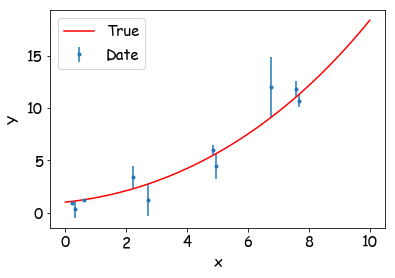

In [2]:
#
# set up our true model
n = 100
x = np.linspace(0., 10., n)
y = lambda x: 0.1*x**2 + 0.1*x + np.exp(.2*x)

#
# pick 10 random points
np.random.seed(12) # set the seed
m = 10
indices = np.random.randint(0, x.size, size=m)

# make mock data
x_data = x[indices]
ye_data = np.random.normal(0,1, size=m)
y_data = y(x_data) + ye_data

# visualize
plt.rc('font', size=15, family='fantasy')
plt.plot(x, y(x), 'r-', label='True')
plt.errorbar(x_data, y_data, yerr=ye_data, ls='None', marker='.', label='Date')
plt.xlabel('x')
plt.ylabel('Y')
plt.legend()

Here we define our model, log likelihood, and log priors and posteriors

In [3]:
# define likelihood and posterior
model = lambda xs, a, b, c: xs**2 * a + xs * b + np.exp(c*xs)

def ln_like(params, xs, observed_yis, yi_uncertainties):
    model_yis = model(xs, *params)
    chi2s = ((observed_yis - model_yis) / yi_uncertainties)**2
    return np.sum(-0.5 * chi2s - 0.5*np.log(2*np.pi) - np.log(yi_uncertainties))

def ln_prior(params):
    if np.any(params < 0) or np.any(params > 1.5):
        return - np.inf
    return 0.

def ln_post(params, xs, observed_yis, yi_uncertainties):
    lnprior_val = ln_prior(params)
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, xs, observed_yis, yi_uncertainties)
        return lnprior_val + lnlike_val

Run 50 MCMC walkers in 3 dimensional parameter space (remember our goal is to constarin 3 parameters). The initial position of random walkers are sampled from a uniform distribution ie. U(0,2). Each walker takes 500 steps

In [4]:
ndim = 3
nwalkers = 50

starting_params = np.random.uniform(0, 2, ndim*nwalkers).reshape((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[x_data, y_data, np.abs(ye_data)])

num_steps = 500
pos, prob, state = sampler.run_mcmc(starting_params, num_steps)

Visualization of walkers paths along each axis (a, b, and c)

Text(0.5,0,'steps')

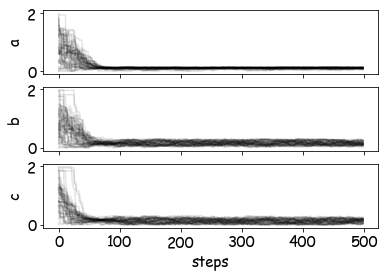

In [11]:
fig, ax = plt.subplots(ndim, sharex=True)
ylabels = ['a','b','c']
for i in range(ndim):
    ax[i].set_ylabel(ylabels[i])
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.1);
ax[2].set_xlabel('steps')

It is clear that we need to dump first 50-100 steps (as known as burn-in steps)

In [6]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

Here we find the 5%, 50% and 95% quantitles of each parameter (ie. the quantiles of the MCMC walkers along each dimension in the parameter space)

In [14]:
m_mcmc, b_mcmc, c_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [5, 50, 95],
                                                axis=0)))
m_mcmc, b_mcmc, c_mcmc

((0.12093701867583284, 0.022359351940220401, 0.055317799421748665),
 (0.17006545102670426, 0.11559004960604943, 0.10390189242584785),
 (0.1323556118937346, 0.12132561267721456, 0.11750366024265466))

We replot the data and the true underlying model while over-plotting a shaded region with 90% CL. from MCMC walkers 

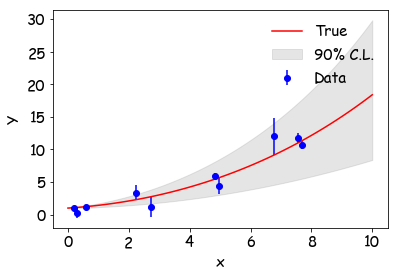

In [15]:
plt.plot(x, y(x), 'r-', label='True')
plt.errorbar(x_data, y_data, yerr=ye_data, marker='o', ls='None', c='b', label='Data')

mn = m_mcmc[0]-m_mcmc[2]
mp = m_mcmc[0]+m_mcmc[1]
bn = b_mcmc[0]-b_mcmc[2]
bp = b_mcmc[0]+b_mcmc[1]
cn = c_mcmc[0]-c_mcmc[2]
cp = c_mcmc[0]+c_mcmc[1]

plt.fill_between(x, y1=model(x, *(mn, bn, cn)), y2=model(x, *(mp,bp, cp)),
                 alpha=0.2, color='grey', label=r'90% C.L.')
plt.xlabel('x')
plt.ylabel('Y')
plt.legend(frameon=False)

Now we use the <a href="http://corner.readthedocs.io/en/latest/pages/quickstart.html">corner</a> module to make a corner plot

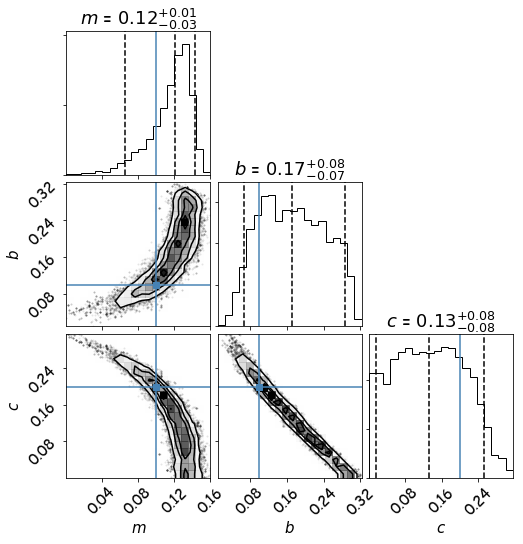

In [16]:
fid = corner.corner(samples, labels=["$m$", "$b$", '$c$'],
                      truths=[.1, 0.1, 0.2], quantiles=[.05,.50,.95], show_titles=True)